ADT7320 ID Register: 0xc3
Tcrit Setpoint     : 147.0 C
Thigh Setpoint     : 64.0 C
Tlow Setpoint      : 10.0 C
Thyst Setpoint     : 5 C

Temperature: 29.25 C


<IPython.core.display.Javascript object>


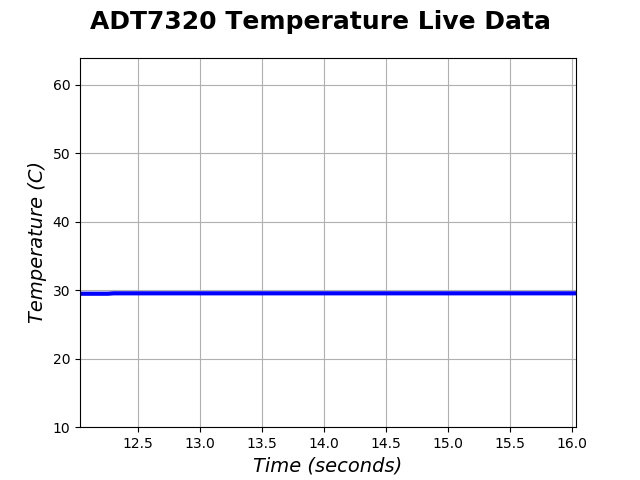

<IPython.core.display.Javascript object>


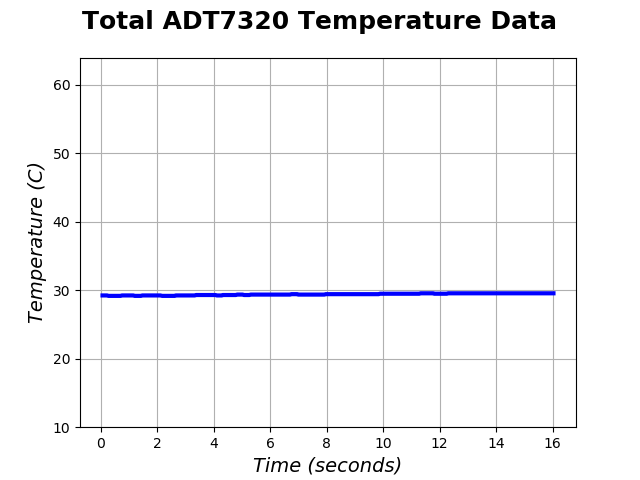

In [1]:
#
# Temperature Sensor Demo
#
%matplotlib notebook

import serial
import numpy as np
from matplotlib import pyplot as plt
from time import time
#
# Please change here to proper COM port name
#
ser = serial.Serial('COM13', 115200)
#
# ADT7320 register access functions
#
def ADT7320_read_reg8(reg):
    ser.reset_input_buffer()
    cmd = "<%0.2x..>" % (reg*8 + 64)  # 
    ser.write(bytearray(cmd,'utf8'))  # Send read register command
    s = ser.read(2)                   # Read data byte
    return int(s,16)                  # return unsigned 8 bit int

def ADT7320_read_reg16(reg):
    ser.reset_input_buffer()
    cmd = "<%0.2x....>" % (reg*8 + 64) # 
    ser.write(bytearray(cmd,'utf8'))   # Send read register command
    s = ser.read(4)                    # Read two data bytes
    x = int(s,16)                      # Convert hex to int
    if x > 32768: x = x - 65536        # Convert to signed int
    return x    

ser.flushInput()
ser.reset_input_buffer() #

ser.write(b'[1]')    # Select UHSA ADT Channel

print('ADT7320 ID Register:', hex(ADT7320_read_reg8(3)))
print("Tcrit Setpoint     :", ADT7320_read_reg16(4)/128, "C")
print("Thigh Setpoint     :", ADT7320_read_reg16(6)/128, "C")
print("Tlow Setpoint      :", ADT7320_read_reg16(7)/128, "C")
print("Thyst Setpoint     :", ADT7320_read_reg8(5), "C")
#
#
#
print("")
print("Temperature:",ADT7320_read_reg16(2)/128, "C")

plt.ion() 
start_time = time()
timepoints = []
ydata = []

# yrange = [25.0,45.0]
yrange = [10.0, 64.0]
view_time = 4 # seconds of data to view at once
duration = 16 # total seconds to collect data

fig1 = plt.figure()
fig1.suptitle('ADT7320 Temperature Live Data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time (seconds)', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature (C)', fontsize='14', fontstyle='italic')

line1, = plt.plot(ydata, color="blue", linewidth=3.0)   # RNM 1/03/19 changed line color and thickness

plt.ylim(yrange)
plt.xlim([0,view_time])

ser.flushInput() # Flush junk
ser.reset_input_buffer()

run = True

# collect the data and plot a moving frame
while run:
    # 
    try:
        y = ADT7320_read_reg16(2)/128

        # store the entire dataset for later
        ydata.append(y)
        
        timepoints.append(time()-start_time)
        current_time = timepoints[-1]
        
        # update the plotted data
        line1.set_xdata(timepoints)
        line1.set_ydata(ydata)
        
        # slide the viewing frame along
        if current_time > view_time:
            plt.xlim([current_time-view_time,current_time])
            
        # when time's up, kill the collect + plot loop
        if timepoints[-1] > duration: run=False
    
    # if the try statement throws an error, just do nothing
    except: pass
    
    # update the plot
    fig1.canvas.draw()
    
# plot all of the data you collected
fig2 = plt.figure()
fig2.suptitle('Total ADT7320 Temperature Data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time (seconds)', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature (C)', fontsize='14', fontstyle='italic')

plt.plot(timepoints, ydata, color="blue", linewidth=3.0) # RNM 1/03/19 changed line color and thickness
plt.ylim(yrange)
fig2.show()

            
ser.close()
